### Import the necessary libraries

In [1]:
# Path to user functions
import sys
sys.path.append("../Src/")
# display Python Version
from platform import python_version
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# user functions
import utilities as u
import statistical_testing as st
import plot_function as pf

# Initialize variables
RANDOM_STATE = 1776

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

Numpy Version: 2.3.1
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.10.0
Python Version: 3.13.5


### Load the dataset & Combine the train and test datasets

In [2]:
# Load the CSV files
print("Loading fraudTrain.csv...")
fraud_train = pd.read_csv("../Data/fraudTrain.csv")
print(f"Training data shape: {fraud_train.shape}")

print("\nLoading fraudTest.csv...")
fraud_test = pd.read_csv("../Data/fraudTest.csv")
print(f"Test data shape: {fraud_test.shape}")

# Combine the datasets
print("\nCombining datasets...")
df = pd.concat([fraud_train, fraud_test], ignore_index=True)
print(f"Combined data shape: {df.shape}")

# reset index after concatenation
df.reset_index(drop=True, inplace=True)

Loading fraudTrain.csv...
Training data shape: (1296675, 23)

Loading fraudTest.csv...
Training data shape: (1296675, 23)

Loading fraudTest.csv...
Test data shape: (555719, 23)

Combining datasets...
Combined data shape: (1852394, 23)
Test data shape: (555719, 23)

Combining datasets...
Combined data shape: (1852394, 23)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [4]:
# Checking for nulls
df.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [5]:
df.is_fraud.value_counts()

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

In [6]:
df.is_fraud.value_counts(normalize=True)

is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64

### Observations :
- From above we can observe that there is 23 features and 1,852,394 rows
- This is highly imbalanced class data
    - We can try with the imbalabnce but we need to balance the dependent variable

In [7]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


### Data Wrangling

In [8]:
# # remove columns
# remove_cols = ['Unnamed: 0', 'street', 'trans_num', 'unix_time', ]
# # drop columns
# df.drop(columns=remove_cols, inplace=True, errors='ignore')

# Convert trans_date_trans_time to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
# Convert dob to datetime
df['dob'] = pd.to_datetime(df['dob'])

# remove 'fraud_' prefix from the 'merchant' column
df['merchant'] = df['merchant'].str.replace('^fraud_', '', regex=True)

# display
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


## Feature Engineering

In [9]:
# Current date
today = pd.Timestamp.today()

# determine month, day of the week
df['trans_qtr'] = df.trans_date_trans_time.dt.quarter
df['trans_month'] = df.trans_date_trans_time.dt.month
df['trans_day'] = df.trans_date_trans_time.dt.day
df['trans_day_of_week'] = df.trans_date_trans_time.dt.dayofweek
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_week_of_year'] = df['trans_date_trans_time'].dt.isocalendar().week
df['is_weekend'] = df['trans_day_of_week'].isin(['Saturday', 'Sunday'])

# For cyclical features like month, day_of_week, hour_of_day, consider sine and cosine transformations to preserve their cyclical nature 
# (e.g., 23:00 is closer to 00:00 than to 12:00).
# For example, you can create sine and cosine transformations for the hour of the day:
df['trans_hour_sin'] = np.sin(2 * np.pi * df['trans_hour'].astype(int) / 24)
df['trans_hour_cos'] = np.cos(2 * np.pi * df['trans_hour'].astype(int) / 24)

df['trans_month_sin'] = np.sin(2 * np.pi * df['trans_month'].astype(int) / 12)
df['trans_month_cos'] = np.cos(2 * np.pi * df['trans_month'].astype(int) / 12)

df['trans_day_of_week_sin'] = np.sin(2 * np.pi * df['trans_day_of_week'].astype(int) / 7)
df['trans_day_of_week_cos'] = np.cos(2 * np.pi * df['trans_day_of_week'].astype(int) / 7)

# Calculate age
df['age'] = df['dob'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))

#
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_hour,trans_week_of_year,is_weekend,trans_hour_sin,trans_hour_cos,trans_month_sin,trans_month_cos,trans_day_of_week_sin,trans_day_of_week_cos,age
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,0,1,False,0.0,1.0,0.5,0.866025,0.781831,0.62349,37
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,0,1,False,0.0,1.0,0.5,0.866025,0.781831,0.62349,47
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,0,1,False,0.0,1.0,0.5,0.866025,0.781831,0.62349,63
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,0,1,False,0.0,1.0,0.5,0.866025,0.781831,0.62349,58
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,0,1,False,0.0,1.0,0.5,0.866025,0.781831,0.62349,39


### New Features

In [10]:
# Create a mapping for industry identifier
mii_to_industry = {
    '1': 'Airlines',
    '2': 'Airlines & Financial',
    '3': 'Travel & Entertainment (e.g., American Express, Diners Club)',
    '4': 'Banking & Financial (e.g., Visa)',
    '5': 'Banking & Financial (e.g., Mastercard)',
    '6': 'Merchandising & Banking (e.g., Discover)',
    '7': 'Petroleum',
    '8': 'Healthcare & Telecommunications',
    '9': 'National Assignment / Other'
}

# apply lamda function to map first digit of cc_num to industry
df['industry'] = df['cc_num'].apply(lambda x: u.map_first_digit_to_value(x, mapping_dict=mii_to_industry))

# determe credit card network
df['cc_network'] = df['cc_num'].apply(lambda x: u.get_credit_card_network(str(x)))

# determine store distance
df['store_distance'] = df.apply(
    lambda x: u.haversine_distance_calc(x['lat'], x['long'], x['merch_lat'], x['merch_long']),
    axis=1
)

# convert amount to log scale
df['amt_log'] = np.log1p(df['amt'])  # Using log1p

# Convert 'is_fraud' to a numeric type (int or float)
df['is_fraud'] = df['is_fraud'].astype(int)  # or float, depending on your data


# Define Non-ordered categorical columns
cat_cols = ['merchant', 'category', 'gender', 'city', 'state', 'zip', 'job', 'is_fraud', 'trans_qtr', 'trans_month', 'trans_day',  
            'trans_day_of_week', 'trans_hour', 'trans_week_of_year', 'industry', 'cc_network']
df[cat_cols] = df[cat_cols].astype('category')


# Display the first few rows of the updated DataFrame
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_hour_cos,trans_month_sin,trans_month_cos,trans_day_of_week_sin,trans_day_of_week_cos,age,industry,cc_network,store_distance,amt_log
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,1.0,0.5,0.866025,0.781831,0.62349,37,Airlines & Financial,Mastercard,48.838332,1.786747
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,1.0,0.5,0.866025,0.781831,0.62349,47,"Merchandising & Banking (e.g., Discover)",Maestro,18.773001,4.684259
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,1.0,0.5,0.866025,0.781831,0.62349,63,"Travel & Entertainment (e.g., American Express...",Diners Club,67.236235,5.398660
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1.0,0.5,0.866025,0.781831,0.62349,58,"Travel & Entertainment (e.g., American Express...",JCB,59.448671,3.828641
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,1.0,0.5,0.866025,0.781831,0.62349,39,"Travel & Entertainment (e.g., American Express...",American Express,48.191592,3.760269


In [11]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_hour_cos,trans_month_sin,trans_month_cos,trans_day_of_week_sin,trans_day_of_week_cos,age,industry,cc_network,store_distance,amt_log
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,1.0,0.5,0.866025,0.781831,0.62349,37,Airlines & Financial,Mastercard,48.838332,1.786747
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,1.0,0.5,0.866025,0.781831,0.62349,47,"Merchandising & Banking (e.g., Discover)",Maestro,18.773001,4.684259
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,1.0,0.5,0.866025,0.781831,0.62349,63,"Travel & Entertainment (e.g., American Express...",Diners Club,67.236235,5.398660
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1.0,0.5,0.866025,0.781831,0.62349,58,"Travel & Entertainment (e.g., American Express...",JCB,59.448671,3.828641
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,1.0,0.5,0.866025,0.781831,0.62349,39,"Travel & Entertainment (e.g., American Express...",American Express,48.191592,3.760269


## Visualization

--- Chi-Square Test between 'trans_hour' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud    0 (count)  1 (count)  0 (%)  1 (%)
trans_hour                                    
0               59832        823   3.25   8.53
1               60503        827   3.28   8.57
2               60003        793   3.26   8.22
3               60165        803   3.26   8.32
4               59877         61   3.25   0.63
5               60008         80   3.26   0.83
6               60352         54   3.28   0.56
7               60229         72   3.27   0.75
8               60439         59   3.28   0.61
9               60170         61   3.27   0.63
10              60268         52   3.27   0.54
11              60111         59   3.26   0.61
12              93210         84   5.06   0.87
13              93398         94   5.07   0.97
14              92989        100   5.05   1.04
15              93339        100   5.07   1.04
16              94192         97   5.11   1.01
17              9

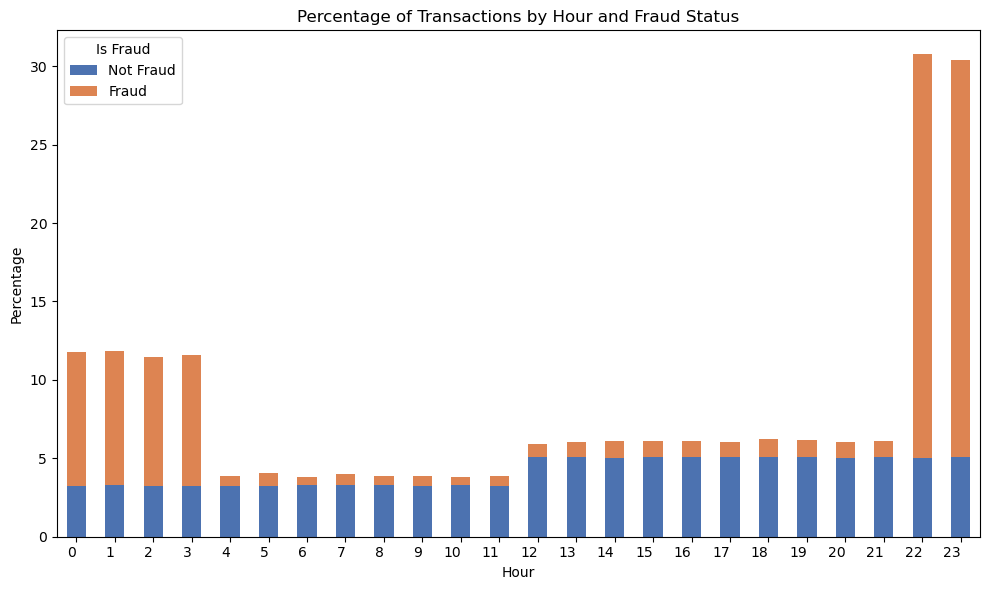

In [12]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df, 'trans_hour', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Hour')
plt.title('Percentage of Transactions by Hour and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()


#### Summary
- The Chi-Square test provides strong statistical evidence to conclude that there is a significant association between the hour of a transaction and whether or not it is fraudulent.
- Fraudulent transactions are disproportionately higher during late-night and early-morning hours (00-03 and especially 22-23). For instance, 25.71% of all fraudulent transactions occur at 22:00, and 25.30% at 23:00, even though these hours account for only about 5% of non-fraudulent transactions.
- Conversely, daytime hours (roughly 04:00 to 21:00) generally see a lower percentage of fraudulent transactions relative to non-fraudulent ones.

--- Chi-Square Test between 'trans_day_of_week' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud           0 (count)  1 (count)  0 (%)  1 (%)
trans_day_of_week                                    
0                     367934       1484  19.97  15.38
1                     269074       1266  14.60  13.12
2                     182788       1125   9.92  11.66
3                     205424       1317  11.15  13.65
4                     213702       1376  11.60  14.26
5                     261734       1493  14.20  15.47
6                     342087       1590  18.56  16.47

Expected Frequencies:
is_fraud                       0            1
trans_day_of_week                            
0                  367493.326784  1924.673216
1                  268931.524622  1408.475378
2                  182954.810564   958.189436
3                  205663.876348  1077.123652
4                  213957.440455  1120.559545
5                  261855.583456  1371.416544
6                  341886.

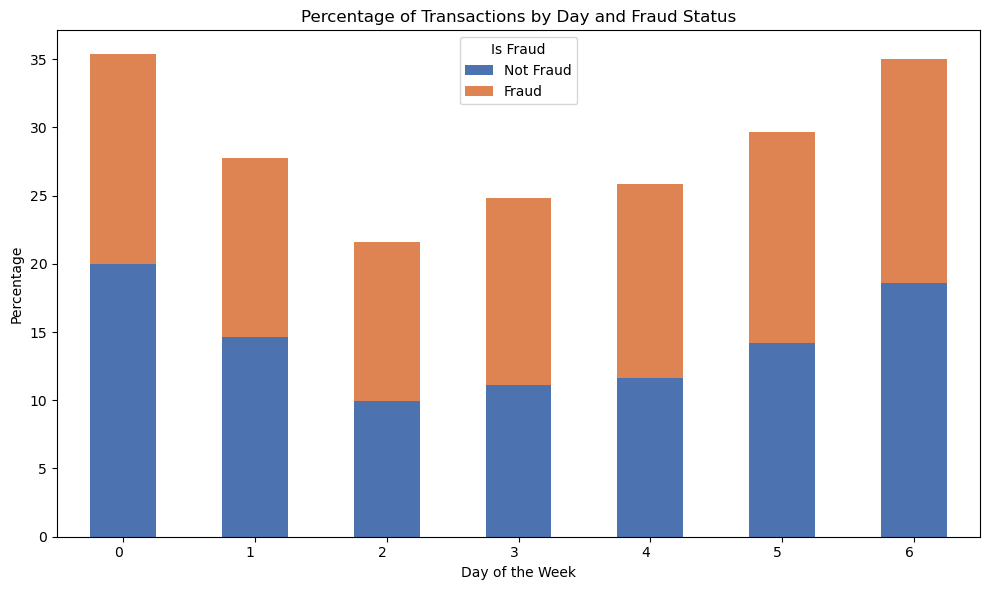

In [13]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df, 'trans_day_of_week', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Day of the Week')
plt.title('Percentage of Transactions by Day and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

#### Summary

- There is a statistically significant relationship between the day of the week and whether a transaction is fraudulent.
- This statistical significance supports the observation that fraudulent activity tends to be more concentrated toward the end of the week.
    - Thursday and Friday have a higher share of fraudulent transactions (13.65% and 14.26% respectively) compared to their share of non-fraudulent transactions (11.15% and 11.60%). This suggests an elevated risk on these days.
    - Monday and Sunday show a lower share of fraudulent transactions (15.38% and 16.47%) relative to their non-fraudulent volume (19.97% and 18.56%), indicating a comparatively lower risk.
    - Saturday fraud is roughly proportionate to its transaction volume, with its share of fraudulent transactions (15.47%) being very close to its share of non-fraudulent transactions (14.20%).
- Fraudulent activity tends to be more concentrated toward the end of the week, particularly on Thursday and Friday. This could reflect the behavioral patterns of fraudsters, who may exploit the end-of-week rush or reduced oversight. 

--- Chi-Square Test between 'trans_month' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud     0 (count)  1 (count)  0 (%)  1 (%)
trans_month                                    
1               103878        849   5.64   8.80
2                96804        853   5.25   8.84
3               142851        938   7.75   9.72
4               134292        678   7.29   7.03
5               145940        935   7.92   9.69
6               173048        821   9.39   8.51
7               171792        652   9.32   6.76
8               175321        797   9.51   8.26
9               139427        758   7.57   7.85
10              137268        838   7.45   8.68
11              142374        682   7.73   7.07
12              279748        850  15.18   8.81

Expected Frequencies:
is_fraud                 0            1
trans_month                            
1            104181.370789   545.629211
2             97148.205593   508.794407
3            143039.857194   749.142806
4            1

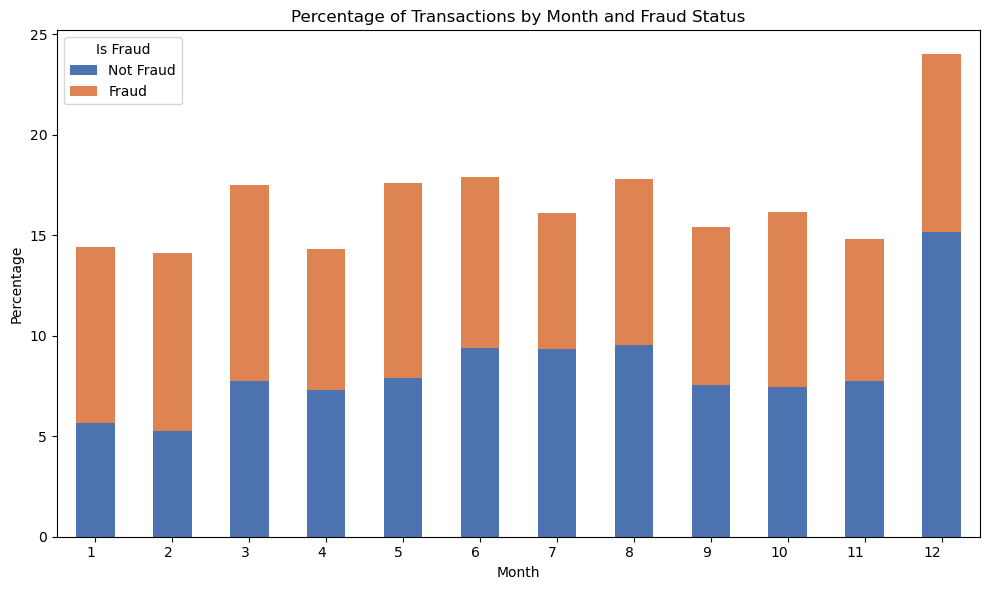

In [14]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df, 'trans_month', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Month')
plt.title('Percentage of Transactions by Month and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

#### Summary
- The Chi-Square test provides strong statistical evidence to conclude that there is a significant association between the month of a transaction and whether or not it is fraudulent.
- Some months, like January, February, March, and May, appear to have a relatively higher proportion of fraudulent transactions compared to their overall transaction volume.
- Conversely, months like December, July, April, and November, show a comparatively lower proportion of fraud relative to their total transaction activity. December is particularly notable for its high volume of non-fraudulent transactions but a relatively lower percentage of fraud.
- This finding suggests that the month of the year is a relevant factor in understanding and potentially predicting fraudulent activity. Further investigation into seasonal patterns, holidays, or specific events occurring in these months could provide deeper insights into the underlying reasons for these variations.

--- Chi-Square Test between 'category' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud        0 (count)  1 (count)  0 (%)  1 (%)
category                                          
entertainment      133826        292   7.26   3.03
food_dining        130524        205   7.08   2.12
gas_transport      187257        772  10.16   8.00
grocery_net         64703        175   3.51   1.81
grocery_pos        173963       2228   9.44  23.09
health_fitness     122368        185   6.64   1.92
home               175195        265   9.51   2.75
kids_pets          161423        304   8.76   3.15
misc_net            89472       1182   4.86  12.25
misc_pos           113907        322   6.18   3.34
personal_care      129795        290   7.04   3.00
shopping_net       137103       2219   7.44  22.99
shopping_pos       165407       1056   8.98  10.94
travel              57800        156   3.14   1.62

Expected Frequencies:
is_fraud                    0           1
category                       

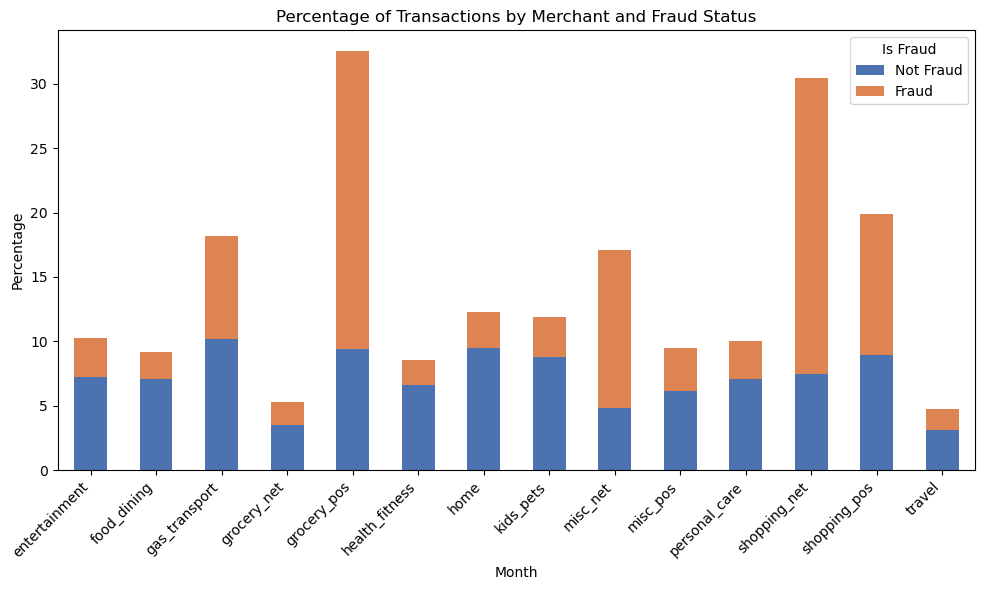

In [15]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df, 'category', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Month')
plt.title('Percentage of Transactions by Merchant and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Summary
- This Chi-Square test definitively shows strong statistical evidence that there is a significant association between the transaction 'category' and whether or not a transaction is fraudulent.
- Fraud Risk by Category: Certain transaction categories, most notably 'grocery_pos', 'shopping_net', and 'misc_net', exhibit a significantly higher propensity for fraud compared to their overall transaction volume. These are critical areas for fraud detection and prevention efforts.
- Lower Risk Categories: Conversely, categories like 'entertainment', 'food_dining', 'health_fitness', and 'home' appear to have a relatively lower fraud risk.
- This information is highly valuable for building fraud detection models, implementing targeted fraud prevention rules, or designing specific monitoring for high-risk categories.
    - High-Risk Categories:
        - grocery_pos and shopping_net are top fraud targets, each accounting for 23% of fraud but much lower share of total transactions.
        - misc_net also stands out with 12% of fraud from just 5% of transactions.
    - Low-Risk Categories:
        - Categories like entertainment, food_dining, health_fitness, and travel show significantly less fraud than expected.\

--- Chi-Square Test between 'industry' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud                                                      0 (count)  1 (count)  0 (%)  1 (%)
industry                                                                                        
Airlines                                                          56789        330   3.08   3.42
Airlines & Financial                                             182050        889   9.88   9.21
Banking & Financial (e.g., Mastercard)                            87385        529   4.74   5.48
Banking & Financial (e.g., Visa)                                 595561       3082  32.32  31.93
Merchandising & Banking (e.g., Discover)                         229365       1245  12.45  12.90
Travel & Entertainment (e.g., American Express, Diners Club)     691593       3576  37.53  37.05

Expected Frequencies:
is_fraud                                                        0            1
industry                          

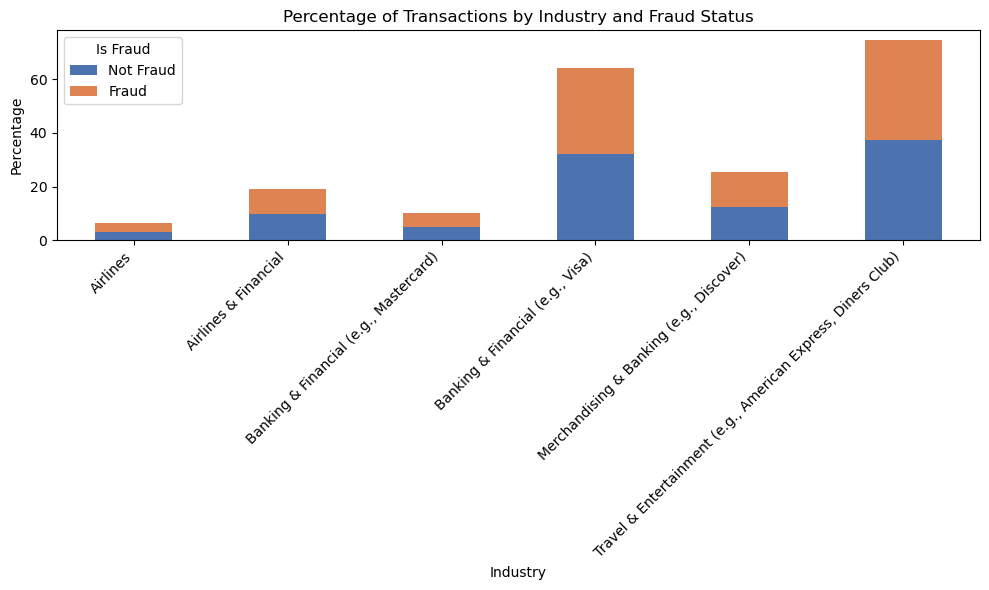

In [16]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df, 'industry', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Industry')
plt.title('Percentage of Transactions by Industry and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Summary
- The Chi-Square test provides statistically significant evidence that there is an association between the 'industry' and whether a transaction is fraudulent.
- While some industries show very proportional fraud rates (like Visa and Amex/Diners Club due to their large overall volumes), others exhibit slight but statistically significant deviations. Specifically:
    - Airlines and Banking & Financial (e.g., Mastercard) show a slightly higher percentage of fraudulent transactions compared to their overall transaction volume, suggesting a marginally elevated risk.
    - Airlines & Financial shows a slightly lower percentage of fraudulent transactions.
    - Although the proportional differences might seem small at first glance, the large number of observations (counts) gives the test enough power to detect these subtle but statistically significant variations. This means the distribution of fraud is not perfectly uniform across these industry types.

--- Chi-Square Test between 'cc_network' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud          0 (count)  1 (count)  0 (%)  1 (%)
cc_network                                          
American Express     176191        898   9.56   9.30
Diners Club          179127        847   9.72   8.78
Discover             149308        776   8.10   8.04
JCB                  208949       1201  11.34  12.44
Maestro              138312        819   7.51   8.49
Mastercard           136917        761   7.43   7.89
Unknown              258378       1267  14.02  13.13
Visa                 595561       3082  32.32  31.93

Expected Frequencies:
is_fraud                      0            1
cc_network                                  
American Express  176166.363704   922.636296
Diners Club       179036.332811   937.667189
Discover          149302.060151   781.939849
JCB               209055.115407  1094.884593
Maestro           138406.125443   724.874557
Mastercard        136960.695594   717.3044

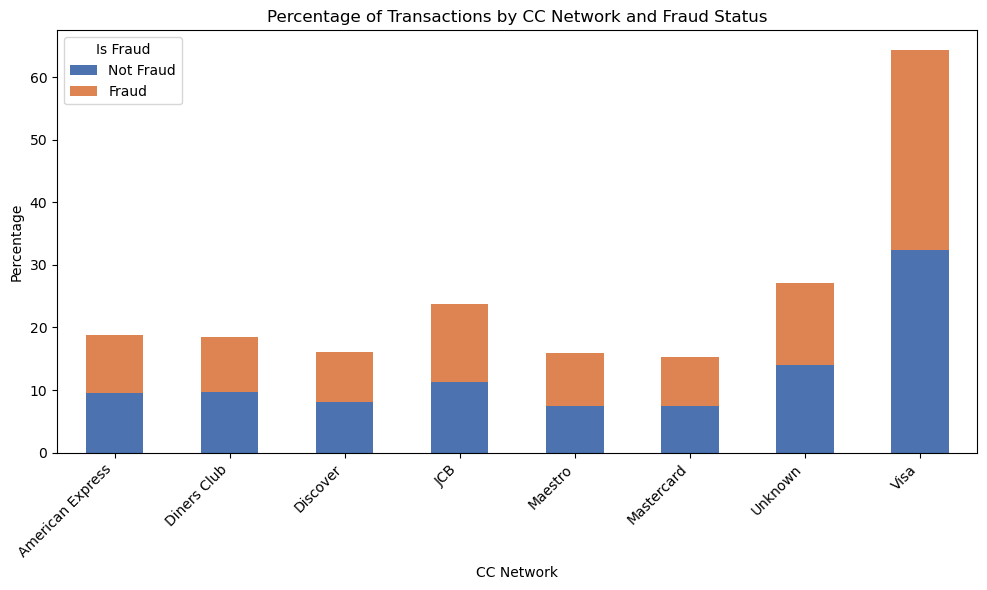

In [17]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df, 'cc_network', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('CC Network')
plt.title('Percentage of Transactions by CC Network and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Summary
- The Chi-Square test provides strong statistical evidence that there is a significant association between the credit card network used for a transaction and whether or not that transaction is fraudulent.
- While some networks like Visa and Discover show very proportional fraud rates (meaning their share of fraud is similar to their share of overall transactions), the statistical significance arises from the deviations seen in other networks:
- JCB and Maestro appear to be slightly overrepresented in fraudulent transactions (meaning a higher percentage of total fraud involves these networks than their percentage of total non-fraudulent transactions).
- Diners Club appears to be slightly underrepresented in fraudulent transactions.
- These differences, although sometimes appearing small in percentage points, are consistently strong enough across the large dataset to be considered statistically significant, meaning they are unlikely due to random chance. This indicates that the credit card network can be a relevant factor in fraud analysis and detection.

--- Chi-Square Test between 'gender' and 'is_fraud' ---
Contingency Table (Observed):
is_fraud  0 (count)  1 (count)  0 (%)  1 (%)
gender                                      
F           1009850       4899  54.80  50.76
M            832893       4752  45.20  49.24

Expected Frequencies:
is_fraud             0            1
gender                             
F         1.009462e+06  5286.857223
M         8.332809e+05  4364.142777

Chi-square Statistic = 63.0910
Degrees of Freedom   = 1
P-value              = 0.0000
➡️ Statistically significant association (Reject Null Hypothesis)


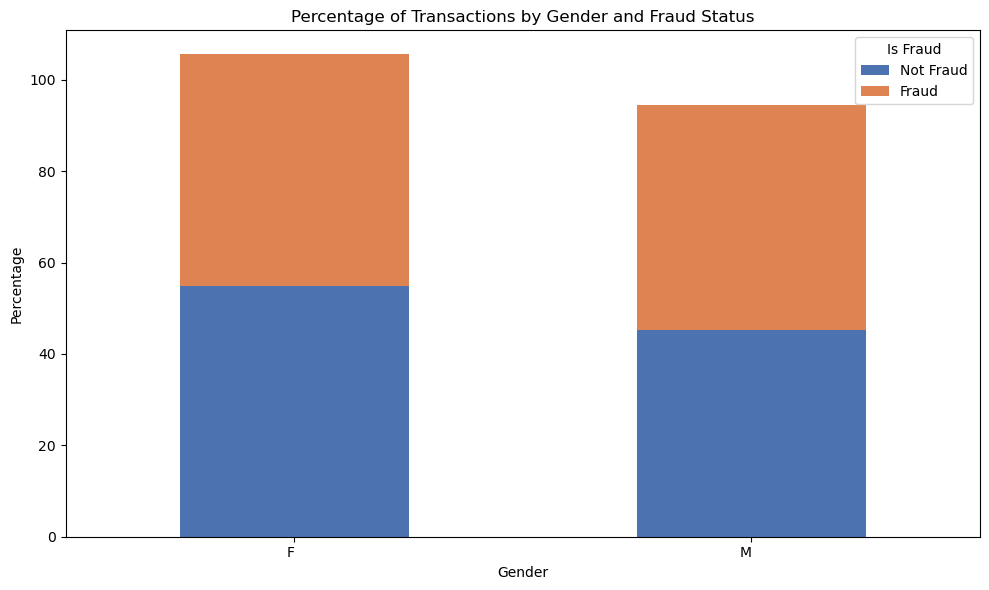

In [18]:
# Perform Chi-Square Test
contingency_table_percent = st.chi_square_test(df, 'gender', 'is_fraud')
contingency_table_percent.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Gender')
plt.title('Percentage of Transactions by Gender and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

#### Summary
- The Chi-Square test provides strong statistical evidence that there is a significant association between 'gender' and whether or not a transaction is fraudulent.
- Although the percentage differences might seem small (e.g., 54.80% vs 50.76% for females), the extremely large sample size allows even these subtle variations to be statistically significant.
- While females account for a larger share of overall transactions, they are slightly less likely to be involved in fraudulent transactions when compared to their overall transaction volume.
- Conversely, males account for a smaller share of overall transactions, but are slightly more likely to be involved in fraudulent transactions when compared to their overall transaction volume.
- This doesn't mean that one gender is inherently "more fraudulent" than the other, but rather that there's a detectable pattern in how fraud manifests across gender categories within this dataset. This insight could be used to inform fraud detection models or risk assessment strategies, as gender appears to be a statistically relevant feature.

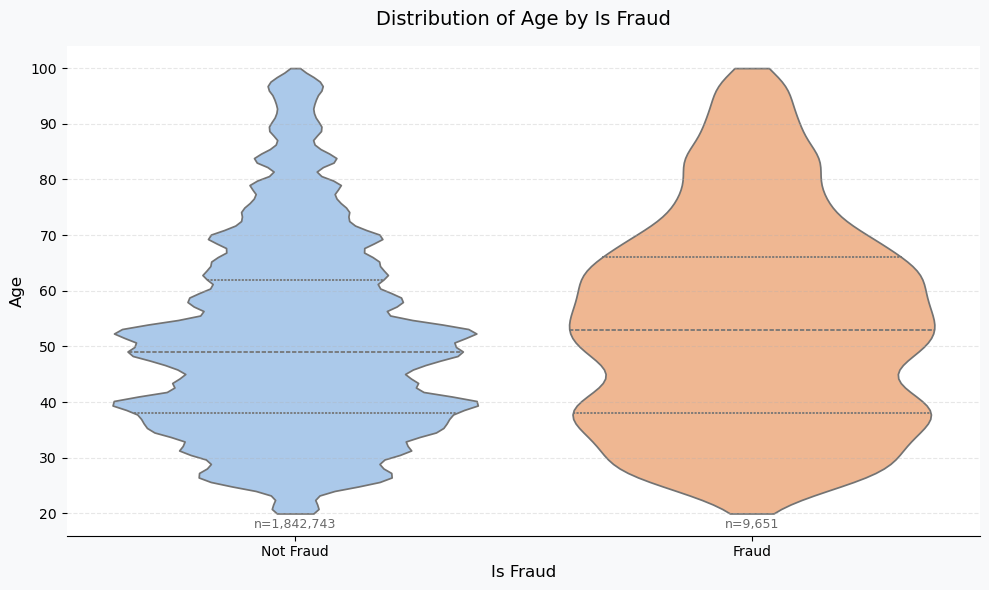

In [19]:
pf.plot_violin_by_binary_category(df, 'is_fraud', 'age')

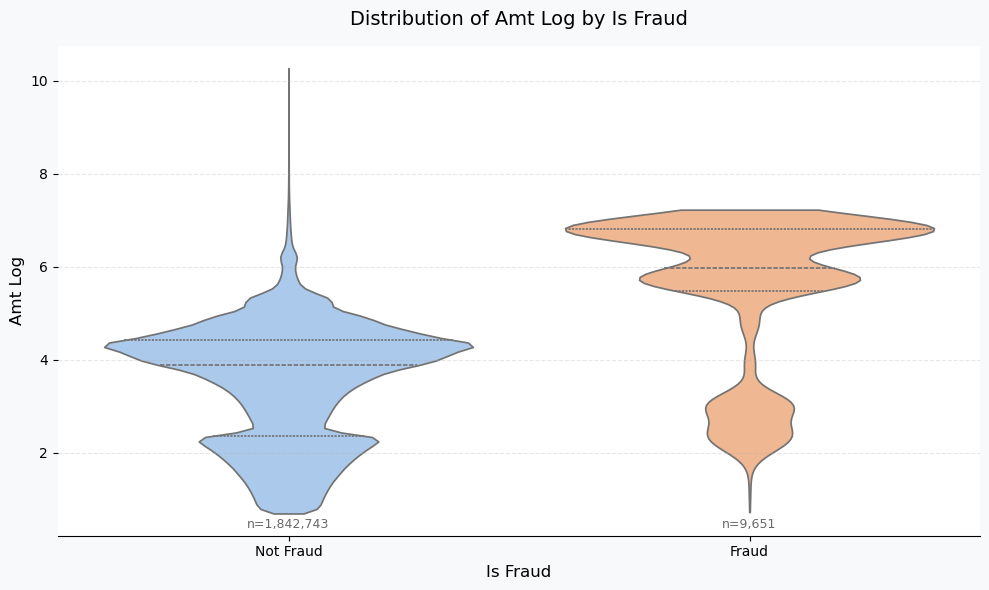

In [20]:
pf.plot_violin_by_binary_category(df, 'is_fraud', 'amt_log')

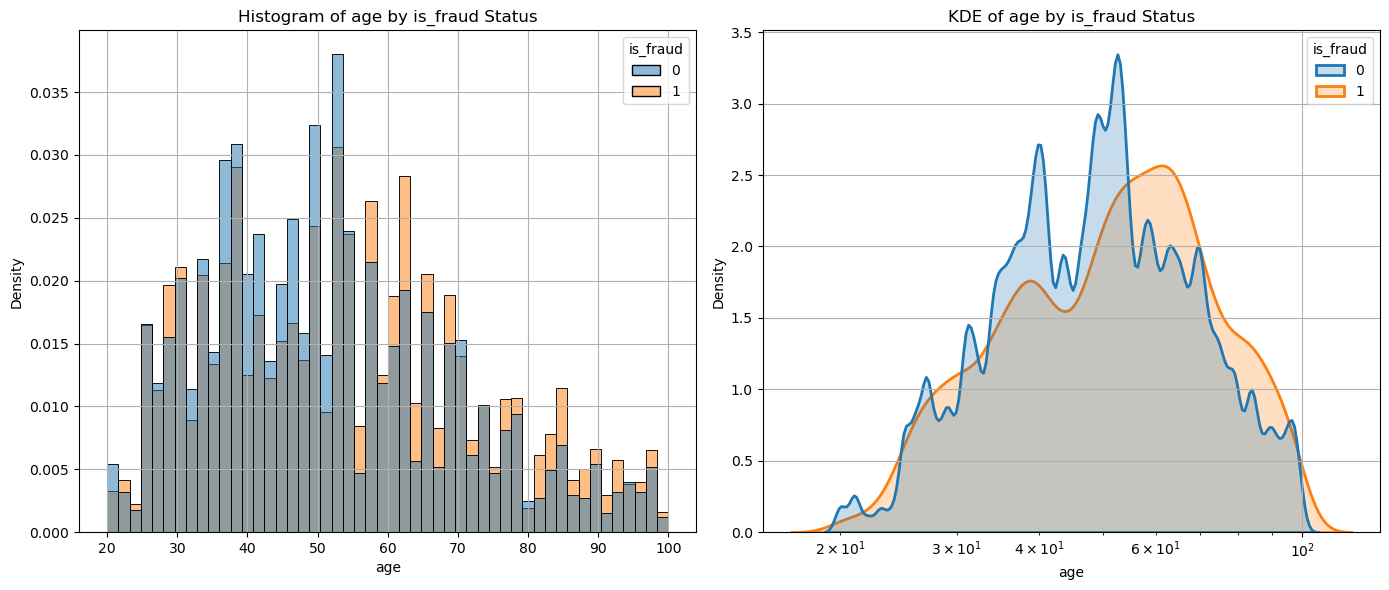

In [21]:
pf.plot_distribution(df, 'age', 'is_fraud', log_scale=False, bins=50)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 41 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Unnamed: 0             int64         
 1   trans_date_trans_time  datetime64[ns]
 2   cc_num                 int64         
 3   merchant               category      
 4   category               category      
 5   amt                    float64       
 6   first                  object        
 7   last                   object        
 8   gender                 category      
 9   street                 object        
 10  city                   category      
 11  state                  category      
 12  zip                    category      
 13  lat                    float64       
 14  long                   float64       
 15  city_pop               int64         
 16  job                    category      
 17  dob                    datetime64[ns]
 18  trans_num             